# Прогнозирование свойств топлива

Задача заключается в прогнозировании свойств дизельного топлива на основе его ближней инфракрасной (NIR) спектроскопии. Формально, это задача регрессии, где входными данными являются спектральные характеристики образца, а выходными — измеренные свойства топлива.

## Загрузка и просмотр данных

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
from sklearn.svm import SVR

### Первый датасет (prop)

In [ ]:
# Путь к данным на Google Drive
# https://drive.google.com/file/d/1-H0fHmKIifEDJFIUaYhmnUjtxhMhR-IU/view?usp=drive_link
url_data = 'https://drive.google.com/uc?id=' + '1-H0fHmKIifEDJFIUaYhmnUjtxhMhR-IU'

# Загрузка данных
data_prop = pd.read_csv(url_data, delimiter=',', skiprows=8)

# Удаляем первый и последний столбцы (пустые)
data_prop = data_prop.iloc[:, 1:-1]

# Переименовываем первый столбец в "id"
data_prop.rename(columns={data_prop.columns[0]: "id"}, inplace=True)

data_prop.head()

,id,BP50,CN,D4052,FLASH,FREEZE,TOTAL,VISC
0,17366,230.0,55.1,NaN,NaN,NaN,NaN,1.98
1,17629,188.0,NaN,0.7818,52.0,NaN,NaN,1.16
2,19546,NaN,46.5,0.7883,NaN,-59.5,NaN,1.12
3,20573,NaN,53.6,0.8510,85.0,-7.9,26.8,3.03
4,20622,217.0,NaN,NaN,63.0,-48.2,NaN,1.51


In [ ]:
data_prop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      784 non-null    int64  
 1   BP50    395 non-null    float64
 2   CN      381 non-null    float64
 3   D4052   395 non-null    float64
 4   FLASH   395 non-null    float64
 5   FREEZE  395 non-null    float64
 6   TOTAL   395 non-null    float64
 7   VISC    395 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 49.1 KB


Датасет со свойствами топлива (`data_prop`)

Каждая строка соответствует образцу дизельного топлива.<br>
Признаки:
- `id` — идентификатор образца.
- `BP50`, `CN`, `D4052`, `FLASH`, `FREEZE`, `TOTAL`, `VISC` — физико-химические свойства топлива (целевые переменные для регрессии).

Размерность: (784, 8). <br>
Проблема пропущенных значений: большинство целевых переменных содержат пропуски (около 50% отсутствующих значений).

### Второй датасет (spec)

In [ ]:
# Путь к данным на Google Drive
# https://drive.google.com/file/d/1smgrBH3NMCVOhV_M9TCOtN2HXfnziRy5/view?usp=drive_link
url_data = 'https://drive.google.com/uc?id=' + '1smgrBH3NMCVOhV_M9TCOtN2HXfnziRy5'

# Загрузка данных
data_spec = pd.read_csv(url_data, delimiter=',', skiprows=9)

# Удаляем первый и последний столбцы (пустые)
data_spec = data_spec.iloc[:, 1:-1]

# Переименовываем первый столбец в "id"
data_spec.rename(columns={data_spec.columns[0]: "id"}, inplace=True)

data_spec.head()

,id,750,752,754,756,758,760,762,764,766,...,1532,1534,1536,1538,1540,1542,1544,1546,1548,1550
0,17366,-0.028073,-0.025056,-0.020949,-0.016544,-0.011938,-0.007299,-0.003553,-0.002041,-0.001611,...,0.65470,0.71349,0.77116,0.82997,0.87557,0.91198,0.93393,0.93160,0.92392,0.91500
1,17629,-0.027034,-0.023999,-0.019447,-0.014240,-0.008838,-0.003365,-0.000817,0.000506,-0.000119,...,0.57492,0.63925,0.70760,0.77394,0.83673,0.88214,0.90957,0.91360,0.90302,0.89997
2,19546,-0.024340,-0.021221,-0.016691,-0.011428,-0.006280,-0.000757,0.002302,0.002651,0.002176,...,0.64240,0.70669,0.76800,0.83145,0.88223,0.92153,0.93871,0.94011,0.92486,0.91992
3,20573,-0.021778,-0.018382,-0.014348,-0.010099,-0.005716,-0.001257,0.002011,0.003679,0.004023,...,0.85733,0.91043,0.96178,1.00350,1.04210,1.06650,1.07600,1.07920,1.06970,1.05460
4,20622,-0.022943,-0.019190,-0.014872,-0.009967,-0.005079,-0.000290,0.002779,0.003697,0.002997,...,0.85075,0.90496,0.95795,1.00130,1.04230,1.06750,1.07760,1.07940,1.06870,1.05250


In [ ]:
data_spec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Columns: 402 entries, id to 1550
dtypes: float64(401), int64(1)
memory usage: 2.4 MB


Датасет со спектроскопическими данными (`data_spec`)

Каждая строка соответствует образцу дизельного топлива.<br>
Признаки:
- `id` — идентификатор образца.
- Спектральные значения в диапазоне 750–1550 нм с шагом 2 нм (401 числовой признак).

Размерность: (784, 402).<br>
Потенциальная проблема: высокая размерность входных данных, возможна корреляция между признаками.

Целевая переменная:<br>
Требуется спрогнозировать свойства топлива (BP50, CN, D4052, FLASH, FREEZE, TOTAL, VISC) на основе спектроскопических данных.

## Предобработка данных

### Анализ пропусков

Обработку столбцов выполнять не будем (предобразование имён столбцов к змеиному формату). Кодирование признаков не требуется.<br>
Перейдем к анализу пропусков. Для начала посчитаем общее количество пропусков в каждом датафрейме.

Пропуски в data_prop:
BP50      389
CN        403
D4052     389
FLASH     389
FREEZE    389
TOTAL     389
VISC      389
dtype: int64


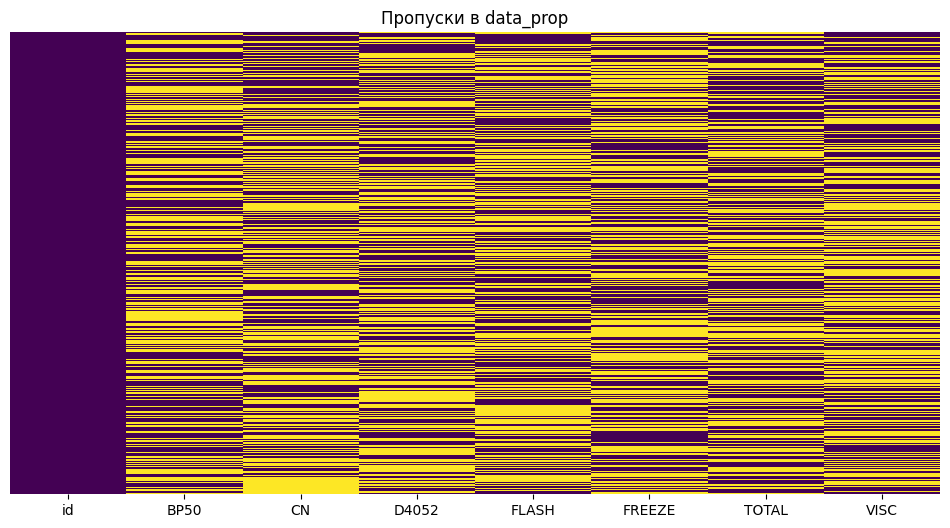

In [ ]:
# Подсчет пропусков
missing_values_prop = data_prop.isnull().sum()

# Вывод количества пропусков
print("Пропуски в data_prop:")
print(missing_values_prop[missing_values_prop > 0])

# Визуализация пропусков
plt.figure(figsize=(12, 6))
sns.heatmap(data_prop.isnull(), cmap="viridis", cbar=False, yticklabels=False)
plt.title("Пропуски в data_prop")
plt.show()


Пропуски в data_spec:
Series([], dtype: int64)


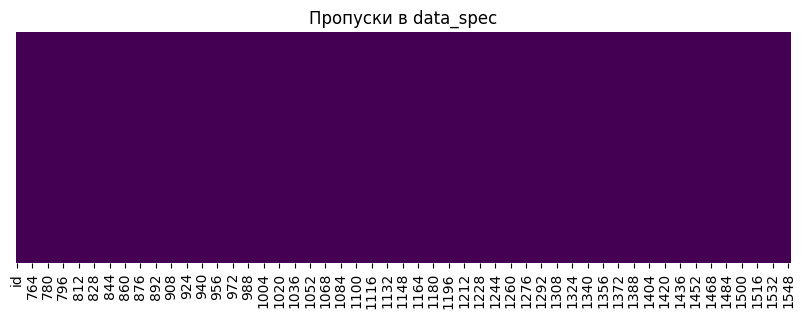

In [ ]:
# Подсчет пропусков
missing_values_spec = data_spec.isnull().sum()

# Вывод количества пропусков
print("\nПропуски в data_spec:")
print(missing_values_spec[missing_values_spec > 0])

# Визуализация пропусков
plt.figure(figsize=(10, 3))
sns.heatmap(data_spec.isnull(), cmap="viridis", cbar=False, yticklabels=False)
plt.title("Пропуски в data_spec")
plt.show()

Во втором датафрейме пропусков нет. Необходимо тчательнее проанализировать первый.<br>
Посмотрим, насколько вероятно, что пропуски в одной переменной связаны с пропусками в другой.

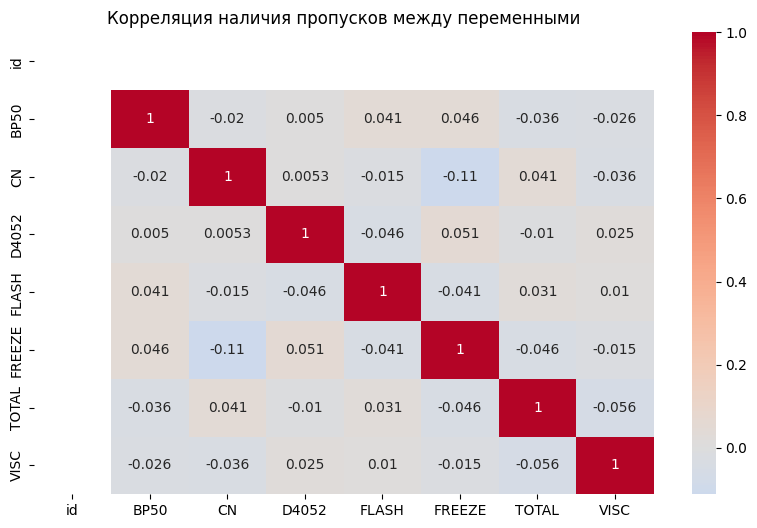

In [ ]:
# Создадим бинарную матрицу пропусков (1 — есть пропуск, 0 — нет)
missing_matrix = data_prop.isnull().astype(int)

# Корреляция наличия пропусков с признаками
corr_missing = missing_matrix.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_missing, annot=True, cmap="coolwarm", center=0)
plt.title("Корреляция наличия пропусков между переменными")
plt.show()

<ipython-input-10-db49cba217a4>:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data_prop[col][data_prop[col].isnull()], label="Пропущенные", ax=ax)
<ipython-input-10-db49cba217a4>:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data_prop[col][data_prop[col].isnull()], label="Пропущенные", ax=ax)
<ipython-input-10-db49cba217a4>:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data_prop[col][data_prop[col].isnull()], label="Пропущенные", ax=ax)
<ipython-input-10-db49cba217a4>:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data_prop[col][data_prop[col].isnull()], label="Пропущенные", ax=ax)
<ipython-input-10-db49cba217a4>:6: UserWarning: Dataset has 0 va

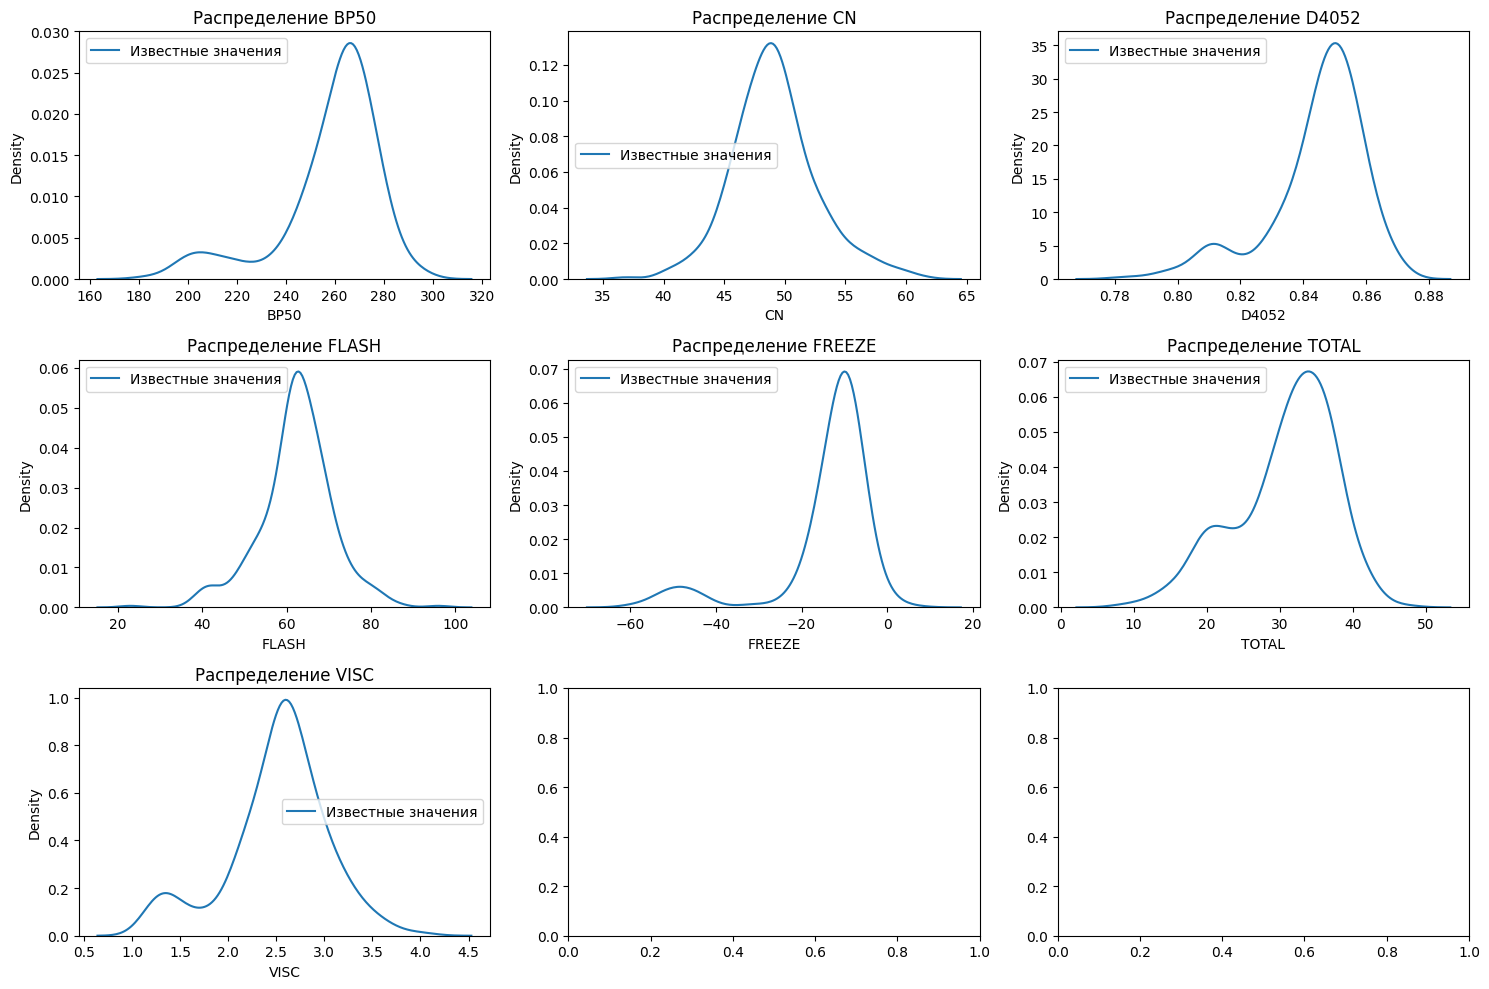

In [ ]:
# Проверим, как отличаются распределения признаков при наличии/отсутствии пропусков
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
columns_to_check = ["BP50", "CN", "D4052", "FLASH", "FREEZE", "TOTAL", "VISC"]
for col, ax in zip(columns_to_check, axes.flatten()):
    sns.kdeplot(data_prop[col], label="Известные значения", ax=ax)
    sns.kdeplot(data_prop[col][data_prop[col].isnull()], label="Пропущенные", ax=ax)
    ax.set_title(f"Распределение {col}")
    ax.legend()

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

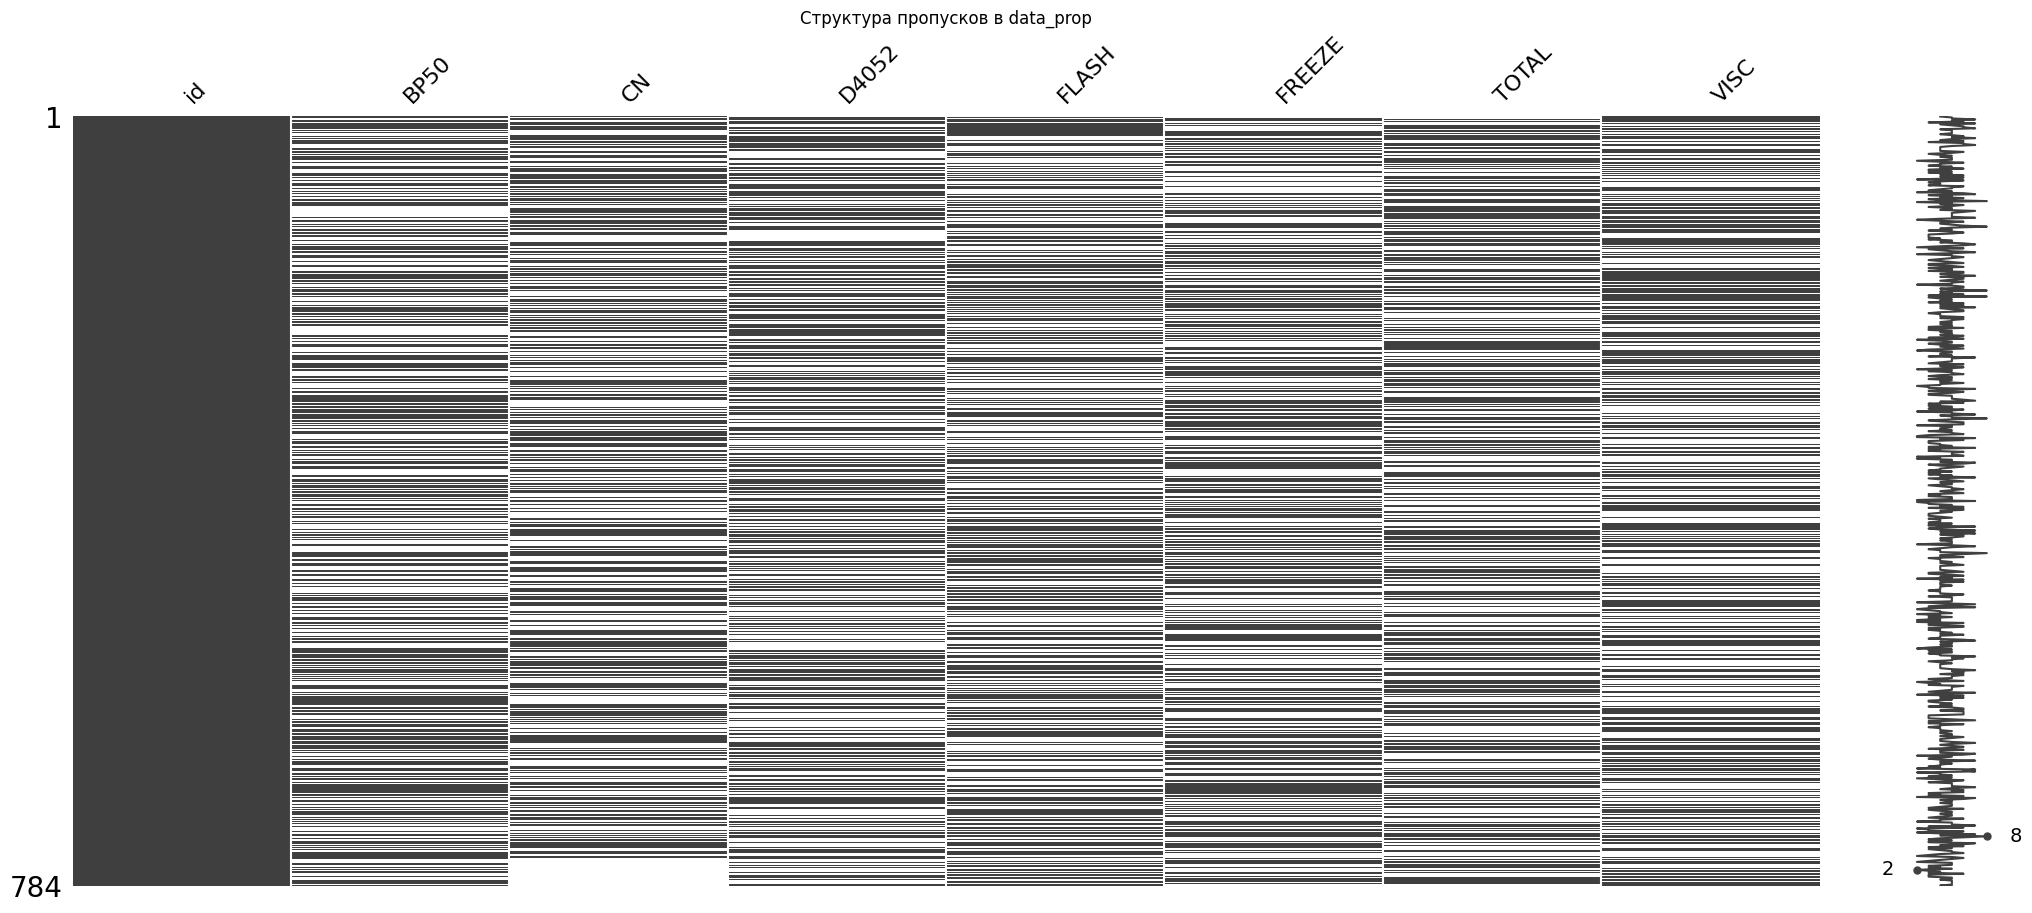

<Figure size 1000x600 with 0 Axes>

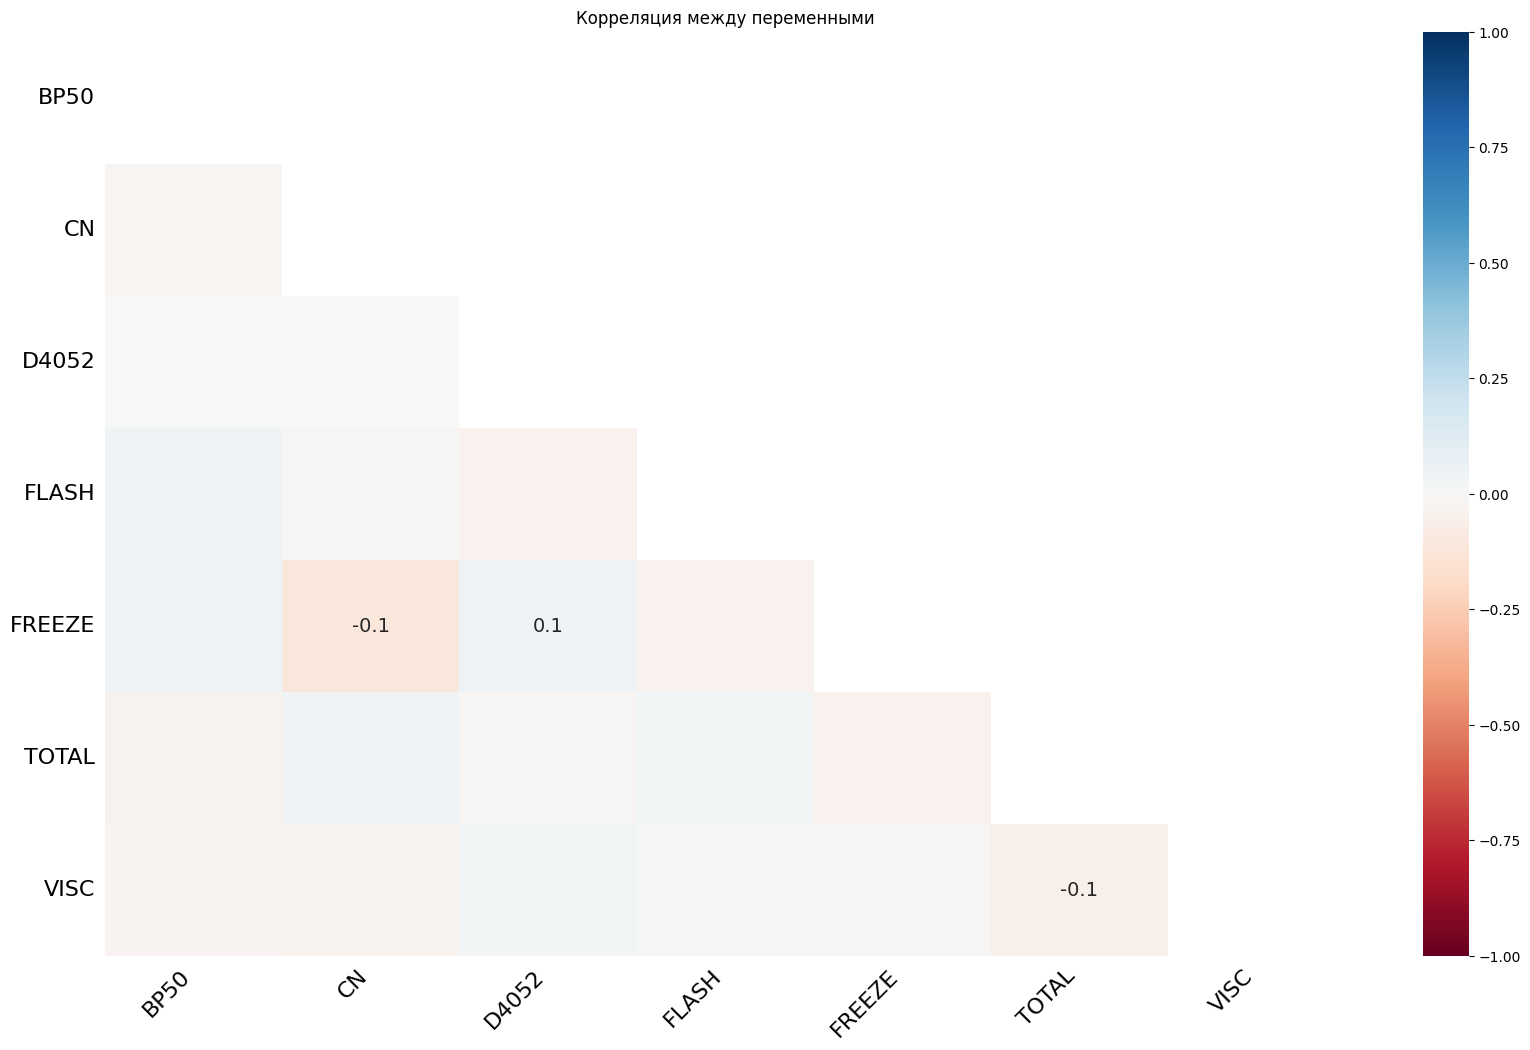

In [ ]:
# Визуализируем паттерны пропусков (чтобы понять, зависят ли пропуски друг от друга)
plt.figure(figsize=(10, 6))
msno.matrix(data_prop)
plt.title("Структура пропусков в data_prop")
plt.show()

plt.figure(figsize=(10, 6))
msno.heatmap(data_prop)
plt.title("Корреляция между переменными")
plt.show()

Анализ пропусков в `data_prop` показал, что их распределение носит случайный характер, так как отсутствует значимая корреляция между наличием пропусков в разных переменных. Визуализация структуры пропусков подтверждает, что они равномерно распределены по датасету, не образуя четких паттернов. Распределения известных значений целевых переменных не демонстрируют значительного сдвига, что исключает зависимость пропусков от значений самих переменных. Все это позволяет классифицировать пропуски как `MCAR` (Missing Completely At Random), то есть они отсутствуют совершенно случайно и их обработка не приведет к систематическим искажениям в модели.

Поскольку объем данных ограничен, удаление строк с пропусками нежелательно, так как это приведет к потере значительной части информации. Вместо этого было принято решение выполнить заполнение пропущенных значений. Учитывая наличие выбросов в некоторых признаках, заполнение средним значением могло бы исказить данные, поэтому выбрана более устойчивая стратегия — замена пропусков медианными значениями соответствующих признаков. Это позволит сохранить структуру данных и уменьшить влияние выбросов на качество модели.

Но перед этим посмотрим, сколько строк в `data_prop` имеют пропуски во всех столбцах одновременно. Такие строки не хранят никакой информации, поэтому логично их удалить.

In [ ]:
# Подсчет строк, где все признаки (кроме id) — NaN
fully_missing_rows = data_prop.iloc[:, 1:].isnull().all(axis=1).sum()

# Выведем результат
print(f"Количество строк, где все признаки отсутствуют: {fully_missing_rows}")

Количество строк, где все признаки отсутствуют: 0


Таких строк не оказалось.

Пропуски было решено не заполнять, поскольку она содержат ~50% исходных данных. В этом случае лучше оставить пропуски как есть.

In [ ]:
# Создание копии на случай, если понадобится исходная версия
data_prop_backup = data_prop.copy()

### Метод главных компонент

После обработки пропусков в целевых переменных `data_prop`, следующим этапом является понижение размерности спектроскопических данных (`data_spec`). В нем содержится 401 числовой признак (длины волн от 750 до 1550 нм), что может привести к избыточности данных, мультиколлинеарности и усложнению модели. Метод главных компонент (PCA – Principal Component Analysis) позволяет извлечь основные информативные компоненты и избавиться от лишних измерений.

План выполнения:
- Разделим data_spec на id и спектральные признаки.
- Стандартизация данных (StandardScaler) — PCA чувствителен к масштабу.
- Применение PCA:
  - Определим количество главных компонент, объясняющих 95% дисперсии. Мы выбираем минимальное число компонент, которые суммарно объясняют 95% дисперсии в данных. Это означает, что мы сохраняем основную информацию, отбрасывая только те компоненты, которые объясняют незначительные вариации.
  - Построим график накопленной дисперсии, чтобы визуально подтвердить выбор.
  - Преобразуем данные в новое пространство.
- Восстановление структуры:
  - Добавим id обратно.
  - Получим уменьшенный data_spec_pca с id и новыми признаками.

In [ ]:
# 1. Отделяем id и спектральные признаки
ids = data_spec["id"]  # Сохраняем id
X_spec = data_spec.drop(columns=["id"])  # Оставляем только спектральные данные

In [ ]:
# 2. Стандартизация данных (PCA чувствителен к масштабу)
scaler = StandardScaler()
X_spec_scaled = scaler.fit_transform(X_spec)

# Также сразу масштабируем целевые переменные
# scaler_y = StandardScaler()
# data_prop.iloc[:, 1:] = scaler_y.fit_transform(data_prop.iloc[:, 1:])  # Масштабируем только целевые переменные

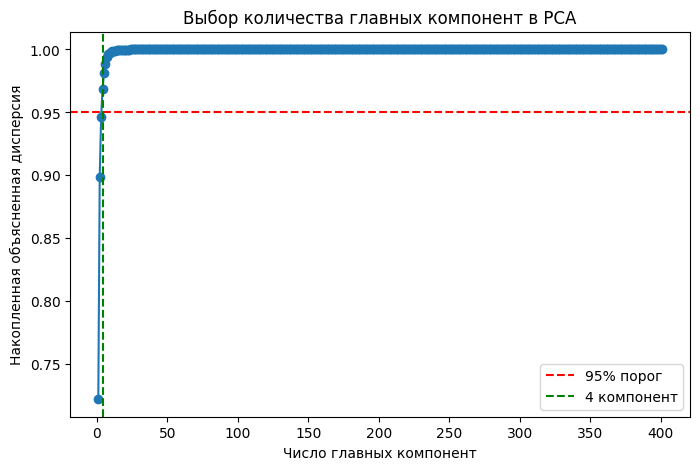

In [ ]:
# 3. Применяем PCA (без указания числа компонент, чтобы сначала проанализировать дисперсию)
pca = PCA()
X_pca = pca.fit_transform(X_spec_scaled)

# 4. Анализ объясненной дисперсии
explained_variance = np.cumsum(pca.explained_variance_ratio_)  # Накопленная дисперсия

# 5. Определяем минимальное количество компонент, дающих 95% дисперсии
n_components_95 = np.argmax(explained_variance >= 0.95) + 1  # +1, так как индексация с 0

# 6. Визуализируем накопленную дисперсию
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% порог")
plt.axvline(x=n_components_95, color='g', linestyle='--', label=f"{n_components_95} компонент")
plt.xlabel("Число главных компонент")
plt.ylabel("Накопленная объясненная дисперсия")
plt.title("Выбор количества главных компонент в PCA")
plt.legend()
plt.show()

Четыре компоненты объясняют 96.85% дисперсии, что означает, что нам удалось сильно уменьшить размерность (401 → 4), практически не теряя информации.

In [ ]:
# 7. Применяем PCA с найденным числом компонент
pca_final = PCA(n_components=n_components_95)
X_pca_reduced = pca_final.fit_transform(X_spec_scaled)

# 8. Создаем новый DataFrame с уменьшенной размерностью и возвращаем id
columns_pca = [f"PC{i+1}" for i in range(n_components_95)]
data_spec_pca = pd.DataFrame(X_pca_reduced, columns=columns_pca)
data_spec_pca.insert(0, "id", ids)  # Вставляем id обратно

# 9. Выводим информацию о новом датасете
print(f"Исходная размерность: {X_spec.shape}")
print(f"Новая размерность после PCA: {data_spec_pca.shape}")
print(f"Объясненная дисперсия выбранных {n_components_95} компонент: {explained_variance[n_components_95-1]:.4f}")


Исходная размерность: (784, 401)
Новая размерность после PCA: (784, 5)
Объясненная дисперсия выбранных 4 компонент: 0.9685


Визуализируем результат.

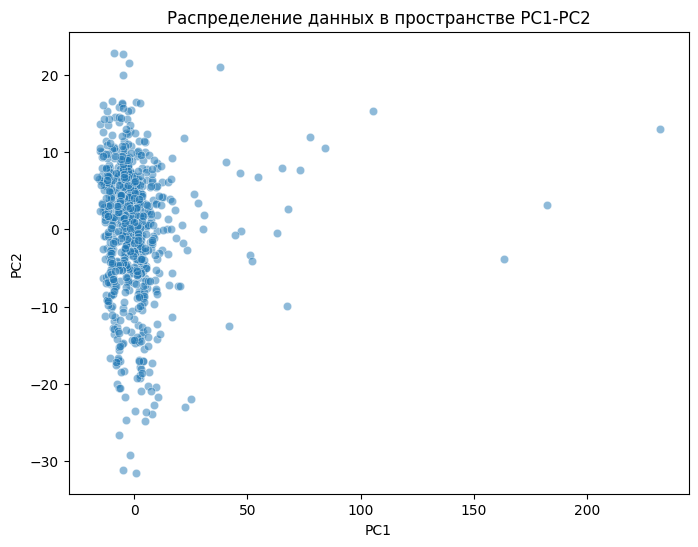

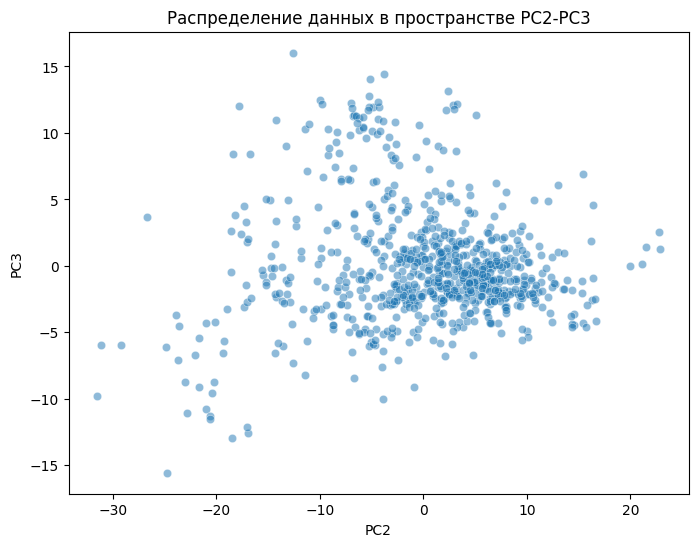

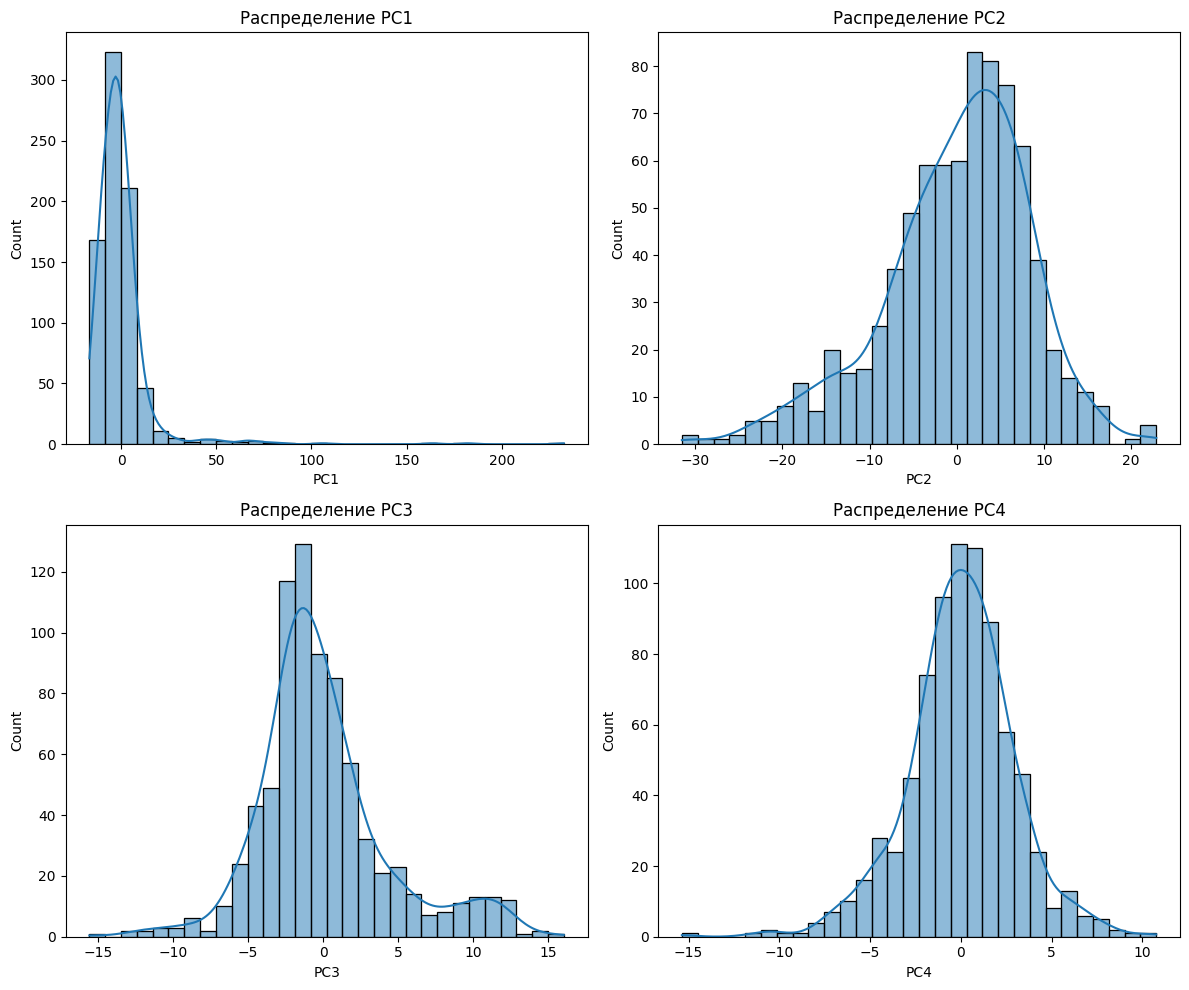

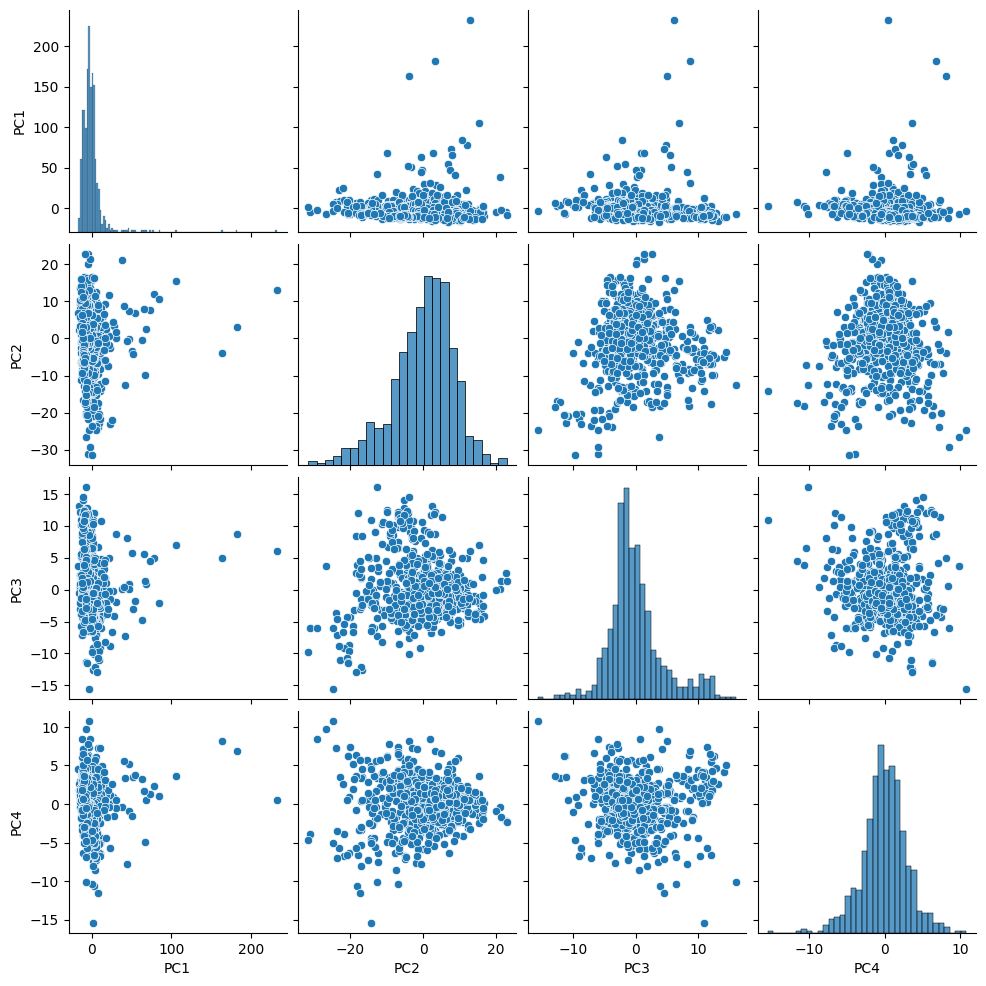

In [ ]:
# 1. Распределение данных в первых двух главных компонентах
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_spec_pca["PC1"], y=data_spec_pca["PC2"], alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Распределение данных в пространстве PC1-PC2")
plt.show()

# 2. График PC2 vs PC3
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_spec_pca["PC2"], y=data_spec_pca["PC3"], alpha=0.5)
plt.xlabel("PC2")
plt.ylabel("PC3")
plt.title("Распределение данных в пространстве PC2-PC3")
plt.show()

# 3. Гистограммы распределений главных компонент
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
components = ["PC1", "PC2", "PC3", "PC4"]
for col, ax in zip(components, axes.flatten()):
    sns.histplot(data_spec_pca[col], bins=30, kde=True, ax=ax)
    ax.set_title(f"Распределение {col}")

plt.tight_layout()
plt.show()

# 4. Pairplot первых четырех компонент
sns.pairplot(data_spec_pca.iloc[:, 1:5])  # Исключаем id
plt.show()

- PC1 имеет асимметричное распределение с длинным "хвостом" вправо, что подтверждает наличие выбросов.
- PC2, PC3 и PC4 демонстрируют приближенно нормальное распределение, что хорошо для дальнейшего моделирования.
<br><br>
- PC1 не имеет явной корреляции с другими компонентами, что говорит о том, что она действительно выделяет уникальную информацию.
- PC2, PC3 и PC4 формируют плотные облака точек, что означает, что они несут основную структурную информацию.

Посмотрим, какие признаки вносят наибольший вклад в каждую компоненту.

In [ ]:
# Матрица весов (loadings) - вклад исходных признаков в главные компоненты
loadings = pd.DataFrame(pca_final.components_, columns=X_spec.columns, index=[f"PC{i+1}" for i in range(n_components_95)])

# Выведем ТОП-5 признаков с наибольшим вкладом в каждую компоненту
top_features_per_pc = {}
for i in range(n_components_95):
    top_features_per_pc[f"PC{i+1}"] = loadings.iloc[i].abs().nlargest(5).index.tolist()

# Выводим признаки, которые наиболее значимы для каждой компоненты
for pc, features in top_features_per_pc.items():
    print(f"{pc}: {features}")

PC1: ['1152', '1154', '1150', '1148', '1156']
PC2: ['1528', '1526', '1530', '1524', '1522']
PC3: ['1226', '1224', '1228', '1230', '1222']
PC4: ['1278', '1280', '1090', '1276', '1260']


### Объединение датафреймов

In [ ]:
# Объединение по id
data_final = data_spec_pca.merge(data_prop, on="id")

# Проверка результата
print(f"Финальная размерность данных: {data_final.shape}")
data_final.head()

Финальная размерность данных: (784, 12)


,id,PC1,PC2,PC3,PC4,BP50,CN,D4052,FLASH,FREEZE,TOTAL,VISC
0,17366,-7.493038,-20.070834,-4.243206,7.453058,230.0,55.1,NaN,NaN,NaN,NaN,1.98
1,17629,-7.000862,-26.688442,3.646360,9.789289,188.0,NaN,0.7818,52.0,NaN,NaN,1.16
2,19546,-4.507980,-18.351248,8.427973,6.381311,NaN,46.5,0.7883,NaN,-59.5,NaN,1.12
3,20573,5.929129,2.087517,-6.803723,-0.005855,NaN,53.6,0.8510,85.0,-7.9,26.8,3.03
4,20622,0.228166,2.554065,6.256232,-0.936388,217.0,NaN,NaN,63.0,-48.2,NaN,1.51


## Реализация методов

### Подготовка данных

In [ ]:
# Разделяем X и Y
X = data_final.drop(columns=["id"] + list(data_prop.columns[1:]))  # Оставляем только PCA-компоненты
Y = data_final[data_prop.columns[1:]]  # Целевые переменные (уже стандартизированы)

# Разделение данных на train/test (80/20)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Вывод размеров выборок
print(f"Размер обучающей выборки: X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"Размер тестовой выборки: X_test: {X_test.shape}, Y_test: {Y_test.shape}")

Размер обучающей выборки: X_train: (627, 4), Y_train: (627, 7)
Размер тестовой выборки: X_test: (157, 4), Y_test: (157, 7)


### Линейная регрессия

В качестве baseline-модели мы выбрали линейную регрессию с регуляризацией (Ridge Regression). Этот метод является расширением обычной линейной регрессии, но дополнительно включает L2-регуляризацию, которая предотвращает переобучение, особенно при наличии высоко коррелированных признаков.

Ridge-регрессия подходит для многомерных данных и позволяет оценить, насколько линейная зависимость между входными признаками (главными компонентами PCA) и целевыми переменными объясняет структуру данных. Если ее качество окажется низким (например, маленький R² и высокий RMSE), это будет указывать на нелинейные зависимости, что оправдает использование более сложных моделей, таких как градиентный бустинг и нейросети.

Благодаря кросс-валидации (5-Fold CV) мы обеспечиваем надежную оценку модели и минимизируем влияние разбиения данных. Подбор гиперпараметра `alpha` с помощью `GridSearchCV` позволяет выбрать оптимальный уровень регуляризации, обеспечивая баланс между точностью и обобщающей способностью модели.

План действий:
1. 1. Индивидуальный подбор гиперпараметра `alpha`
  - Ridge-регрессия содержит параметр регуляризации `alpha`, который контролирует баланс между качеством подгонки и обобщающей способностью модели.
  - Мы подбираем отдельное оптимальное значение `alpha` для каждой целевой переменной, используя `GridSearchCV` на логарифмической сетке (`0.001` до `1000`).
  - Перед подбором удаляются строки, содержащие пропуски в конкретной целевой переменной.
2. Кросс-валидация с учётом пропусков
  - Для каждой переменной применяется 5-Fold Cross-Validation, где в каждом фолде модель обучается и валидируется только на непустых строках этой переменной.
  - Это позволяет максимально использовать доступные данные, даже если в других признаках есть пропуски.
3. Обучение Ridge-модели с найденным `alpha`
  - После подбора оптимального `alpha` модель обучается на тренировочных данных (без `NaN`) по каждому признаку отдельно.
  - Предсказания и метрики рассчитываются с учётом индивидуальных выборок.
4. Оценка модели
  - Для каждой переменной вычисляются метрики:
    - MSE (Mean Squared Error) – среднеквадратичная ошибка.
    - MAE (Mean Absolute Error) – средняя абсолютная ошибка.
    - RMSE (Root Mean Squared Error) – корень из MSE.
    - R² (коэффициент детерминации) – доля объясненной дисперсии.
  - Каждая метрика рассчитывается по среднему и стандартному отклонению на кросс-валидации.
  - Также рассчитываются усреднённые метрики по всем признакам, что даёт общую оценку качества модели.
5. Визуализация результатов
  - Строятся графики реальных vs предсказанных значений для каждой целевой переменной.
  - Это позволяет визуально оценить качество предсказаний, выявить возможное смещение, разброс и выбросы.

In [ ]:
# Гиперпараметры для подбора (разные значения alpha)
param_grid = {'alpha': np.logspace(-3, 3, 10)}  # от 0.001 до 1000

# Кросс-валидация
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Словарь для хранения лучших alpha по каждому признаку
best_alphas = {}

for target in Y_train.columns:
    # Убираем строки с NaN в текущей целевой переменной
    mask = ~Y_train[target].isna()
    X_target = X_train[mask]
    y_target = Y_train[target][mask]

    # Подбор гиперпараметра alpha
    ridge = Ridge()
    grid_search = GridSearchCV(ridge, param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_target, y_target)

    best_alpha = grid_search.best_params_['alpha']
    best_alphas[target] = best_alpha
    print(f"Оптимальный alpha для {target}: {best_alpha}")

Оптимальный alpha для BP50: 0.001
Оптимальный alpha для CN: 0.001
Оптимальный alpha для D4052: 46.41588833612773
Оптимальный alpha для FLASH: 215.44346900318823
Оптимальный alpha для FREEZE: 46.41588833612773
Оптимальный alpha для TOTAL: 10.0
Оптимальный alpha для VISC: 46.41588833612773


In [ ]:
# Инициализируем пустой словарь для хранения метрик
results = {}

# Считаем метрики для каждой целевой переменной отдельно
for target in Y_train.columns:
    # Убираем строки с NaN в текущей целевой переменной
    mask = ~Y_train[target].isna()
    X_target = X_train[mask]
    y_target = Y_train[target][mask]

    # Используем индивидуально подобранный alpha
    ridge = Ridge(alpha=best_alphas[target])

    # Кросс-валидация
    mse_scores = -cross_val_score(ridge, X_target, y_target, cv=cv, scoring='neg_mean_squared_error')
    mae_scores = -cross_val_score(ridge, X_target, y_target, cv=cv, scoring='neg_mean_absolute_error')
    r2_scores = cross_val_score(ridge, X_target, y_target, cv=cv, scoring='r2')

    # Записываем результаты
    results[target] = {
        "MSE (mean ± std)": f"{mse_scores.mean():.4f} ± {mse_scores.std():.4f}",
        "MAE (mean ± std)": f"{mae_scores.mean():.4f} ± {mae_scores.std():.4f}",
        "RMSE (mean ± std)": f"{np.sqrt(mse_scores.mean()):.4f} ± {np.sqrt(mse_scores.std()):.4f}",
        "R² (mean ± std)": f"{r2_scores.mean():.4f} ± {r2_scores.std():.4f}",
    }

# Преобразуем в DataFrame
df_results = pd.DataFrame(results)

# Вычисляем средние значения и стандартное отклонение по всем признакам
average_metrics = {}
for metric in df_results.index:
    values = [float(x.split(" ± ")[0]) for x in df_results.loc[metric].values]  # Средние
    stds = [float(x.split(" ± ")[1]) for x in df_results.loc[metric].values]  # Отклонения
    avg_mean, avg_std = np.mean(values), np.mean(stds)  # Среднее и средняя дисперсия

    # Записываем в таком же формате
    average_metrics[metric] = f"{avg_mean:.4f} ± {avg_std:.4f}"

# Добавляем строку со средними значениями
df_results["Среднее (по всем признакам)"] = pd.Series(average_metrics)

# Выводим таблицу
df_results

,BP50,CN,D4052,FLASH,FREEZE,TOTAL,VISC,Среднее (по всем признакам)
MSE (mean ± std),138.5710 ± 11.8423,6.6086 ± 0.8421,0.0001 ± 0.0000,51.9701 ± 18.8389,48.4918 ± 9.3131,6.7567 ± 1.2987,0.1027 ± 0.0294,36.0716 ± 6.0235
MAE (mean ± std),9.3108 ± 0.5325,1.9589 ± 0.1692,0.0056 ± 0.0005,5.3934 ± 0.7906,5.1158 ± 0.4132,2.0136 ± 0.2229,0.2505 ± 0.0338,3.4355 ± 0.3090
RMSE (mean ± std),11.7716 ± 3.4413,2.5707 ± 0.9176,0.0072 ± 0.0033,7.2090 ± 4.3404,6.9636 ± 3.0517,2.5994 ± 1.1396,0.3205 ± 0.1715,4.4917 ± 1.8665
R² (mean ± std),0.6438 ± 0.0835,0.4304 ± 0.1443,0.7730 ± 0.0532,0.2879 ± 0.0972,0.6226 ± 0.0882,0.8567 ± 0.0174,0.5885 ± 0.1360,0.6004 ± 0.0885


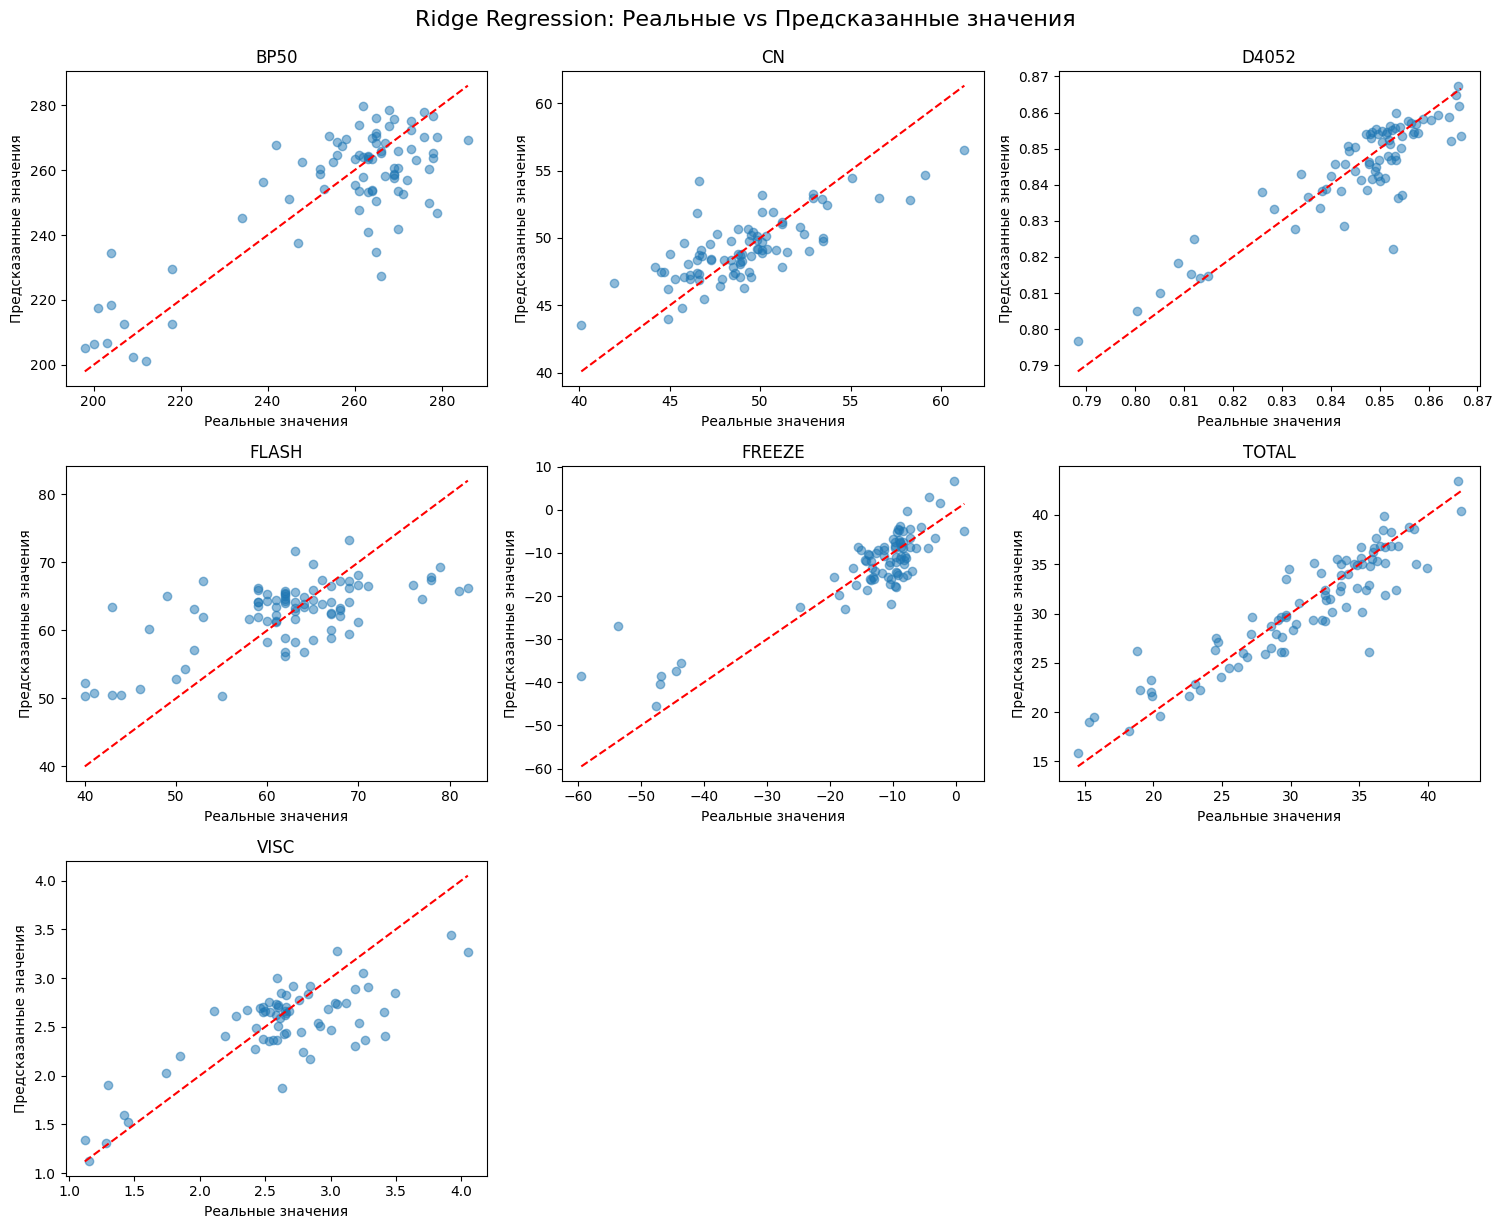

In [ ]:
# Предсказания для тестовой выборки по каждой целевой переменной отдельно
n_cols = 3
n_rows = int(np.ceil(len(Y_test.columns) / n_cols))
plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, target in enumerate(Y_test.columns):
    # Маска без пропусков в целевом признаке
    mask = ~Y_test[target].isna()
    X_target = X_test[mask]
    y_target = Y_test[target][mask]

    # Обучаем Ridge-модель на тренировочной выборке без пропусков
    train_mask = ~Y_train[target].isna()
    ridge = Ridge(alpha=best_alphas[target])
    ridge.fit(X_train[train_mask], Y_train[target][train_mask])

    # Предсказания
    y_pred = ridge.predict(X_target)

    # График
    plt.subplot(n_rows, n_cols, i + 1)
    plt.scatter(y_target, y_pred, alpha=0.5)
    plt.plot([y_target.min(), y_target.max()], [y_target.min(), y_target.max()], color='red', linestyle='--')
    plt.xlabel("Реальные значения")
    plt.ylabel("Предсказанные значения")
    plt.title(f"{target}")

plt.tight_layout()
plt.suptitle("Ridge Regression: Реальные vs Предсказанные значения", fontsize=16, y=1.02)
plt.show()

1. Какие признаки хуже предсказываются?
- Наиболее точно модель предсказывает признаки D4052 (R² = 0.7730 ± 0.0532), TOTAL (R² = 0.8567 ± 0.0174), BP50 (R² = 0.6438 ± 0.0835) и FREEZE (R² = 0.6226 ± 0.0882). Эти признаки демонстрируют устойчивые линейные зависимости от признаков, полученных из спектроскопии, и относительно низкие ошибки (например, MAE около 0.0056 для D4052 и 2.01 для TOTAL). Особенно выделяется TOTAL, где высокая точность сочетается с минимальной дисперсией предсказаний между фолдами.
2. Какие признаки предсказываются лучше?
- Наименее точно модель предсказывает FLASH (R² = 0.2879 ± 0.0972) и CN (R² = 0.4304 ± 0.1443), несмотря на относительно низкие абсолютные значения ошибок. Это может указывать на более сложную (возможно, нелинейную) природу зависимости этих переменных от спектральных данных. У FLASH также наблюдается значительное отклонение по фолдам, что может говорить о нестабильности модели на этих данных.
3. Общий вывод по Ridge:
- Среднее значение коэффициента детерминации по всем признакам составило R² = 0.6004 ± 0.0885, что означает, что модель объясняет около 60% дисперсии целевых переменных. Это приемлемый результат для линейной регрессии, учитывая наличие пропусков и высокую размерность исходных данных. Ошибки предсказаний (MSE, MAE, RMSE) различаются в зависимости от шкалы измерения признаков, но находятся на разумном уровне. В целом, Ridge-регрессия показывает уверенное базовое качество и служит хорошей отправной точкой для сравнения с более сложными моделями.

### Градиентный бустинг (CatBoost)

CatBoost (Categorical Boosting) – это мощный алгоритм градиентного бустинга, разработанный компанией Yandex. Он основан на методе последовательного обучения ансамбля деревьев решений, где каждая новая модель исправляет ошибки предыдущих.

Ключевые особенности CatBoost:
- Устойчивость к переобучению благодаря уникальной схеме построения деревьев.
- Эффективная работа с категориальными признаками (у нас их нет, но это важная особенность).
- Отличная работа на небольших и средних данных, часто превосходит XGBoost и LightGBM по качеству.

План действий:
1. Подготовка данных
- Выделяются входные признаки `X` (PCA-компоненты) и целевые переменные `Y` (сохраняются пропуски).
- Данные разбиваются на обучающую и тестовую выборки в соотношении 80/20, при этом пропуски в `Y` остаются, и будут учитываться далее индивидуально.
2. Подбор гиперпараметров (по каждому признаку)
- Для каждого целевого признака:
  - Удаляются строки с пропущенными значениями.
  - Используется `GridSearchCV` с 5-Fold кросс-валидацией для подбора оптимальных гиперпараметров:
    - `depth` (глубина деревьев),
    - `learning_rate` (скорость обучения),
    - `iterations` (число итераций). Подбор параметров проводится отдельно для каждого признака, чтобы учесть особенности каждой задачи.
3. Обучение CatBoost
- После определения лучших параметров модель обучается для каждого признака:
  - Используются только строки без пропусков в текущем признаке.
  - Обучение выполняется на всей обучающей выборке, соответствующей этому признаку.
  - Предсказания делаются на тестовых данных (также очищенных от пропусков в целевом признаке).
4. Оценка качества модели
- Вычислим MSE, MAE, RMSE, R² для каждого признака отдельно.
- Сформируем таблицу метрик в таком же формате, как для Ridge Regression.
5. Визуализация предсказаний vs реальных значений
- Построим график предсказанных значений vs реальных для первого целевого признака.

In [ ]:
# Разделение данных
X = data_final.drop(columns=["id"] + list(data_prop.columns[1:]))  # PCA-компоненты
Y = data_final[data_prop.columns[1:]]  # Целевые переменные

# Разделяем на train/test (80/20)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Подбираем гиперпараметры только для одного целевого признака (например, BP50)
target_for_tuning = Y_train.columns[0]  # Например, "BP50"

# Удаляем строки с NaN в целевом признаке
mask = ~Y_train[target_for_tuning].isna()
X_target = X_train[mask]
y_target = Y_train[target_for_tuning][mask]

# Задаем сетку гиперпараметров
param_grid = {
    "depth": [4, 6, 8],
    "learning_rate": [0.005, 0.01, 0.05],
    "iterations": [250, 500, 1000]
}

# GridSearchCV с кросс-валидацией
cv = 5
catboost = CatBoostRegressor(verbose=0, random_seed=42)
grid_search = GridSearchCV(catboost, param_grid, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search.fit(X_target, y_target)

# Лучшие параметры
best_params = grid_search.best_params_
print(f"Оптимальные параметры для {target_for_tuning}: {best_params}")

Оптимальные параметры для BP50: {'depth': 4, 'iterations': 1000, 'learning_rate': 0.01}


In [ ]:
# Кросс-валидация
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Словарь для хранения метрик
results = {}

for target in Y_train.columns:
    mse_scores, mae_scores, r2_scores = [], [], []

    for train_idx, val_idx in cv.split(X_train):
        # Отбираем строки фолда
        X_tr_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr_fold, y_val_fold = Y_train[target].iloc[train_idx], Y_train[target].iloc[val_idx]

        # Удаляем строки с NaN в текущем признаке
        train_mask = ~y_tr_fold.isna()
        val_mask = ~y_val_fold.isna()

        X_tr = X_tr_fold[train_mask]
        y_tr = y_tr_fold[train_mask]

        X_val = X_val_fold[val_mask]
        y_val = y_val_fold[val_mask]

        # Обучение модели
        model = CatBoostRegressor(**best_params, verbose=0, random_seed=42)
        model.fit(X_tr, y_tr)

        # Предсказания
        y_pred = model.predict(X_val)

        # Метрики
        mse = np.mean((y_val - y_pred) ** 2)
        mae = np.mean(np.abs(y_val - y_pred))
        r2 = 1 - (np.sum((y_val - y_pred) ** 2) / np.sum((y_val - np.mean(y_tr)) ** 2))

        mse_scores.append(mse)
        mae_scores.append(mae)
        r2_scores.append(r2)

    # Сохраняем метрики
    results[target] = {
        "MSE (mean ± std)": f"{np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}",
        "MAE (mean ± std)": f"{np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}",
        "RMSE (mean ± std)": f"{np.sqrt(np.mean(mse_scores)):.4f} ± {np.sqrt(np.std(mse_scores)):.4f}",
        "R² (mean ± std)": f"{np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}"
    }

# Формируем таблицу результатов
df_results = pd.DataFrame(results)

# Средние значения по всем признакам
average_metrics = {}
for metric in df_results.index:
    values = [float(x.split(" ± ")[0]) for x in df_results.loc[metric].values]
    stds = [float(x.split(" ± ")[1]) for x in df_results.loc[metric].values]
    avg_mean, avg_std = np.mean(values), np.mean(stds)
    average_metrics[metric] = f"{avg_mean:.4f} ± {avg_std:.4f}"

df_results["Среднее (по всем признакам)"] = pd.Series(average_metrics)

# Выводим таблицу
df_results

,BP50,CN,D4052,FLASH,FREEZE,TOTAL,VISC,Среднее (по всем признакам)
MSE (mean ± std),113.9080 ± 14.6933,6.5856 ± 0.7827,0.0000 ± 0.0000,50.8986 ± 15.9301,26.4482 ± 8.7698,6.3714 ± 2.4274,0.0816 ± 0.0120,29.1848 ± 6.0879
MAE (mean ± std),8.1809 ± 0.5046,1.9527 ± 0.1339,0.0047 ± 0.0005,5.3429 ± 0.7527,3.4334 ± 0.3757,1.8347 ± 0.3011,0.2198 ± 0.0191,2.9956 ± 0.2982
RMSE (mean ± std),10.6728 ± 3.8332,2.5662 ± 0.8847,0.0064 ± 0.0033,7.1343 ± 3.9913,5.1428 ± 2.9614,2.5242 ± 1.5580,0.2857 ± 0.1094,4.0475 ± 1.9059
R² (mean ± std),0.7246 ± 0.0336,0.4490 ± 0.1356,0.8212 ± 0.0484,0.3268 ± 0.1042,0.8042 ± 0.0586,0.8674 ± 0.0330,0.6915 ± 0.0326,0.6692 ± 0.0637


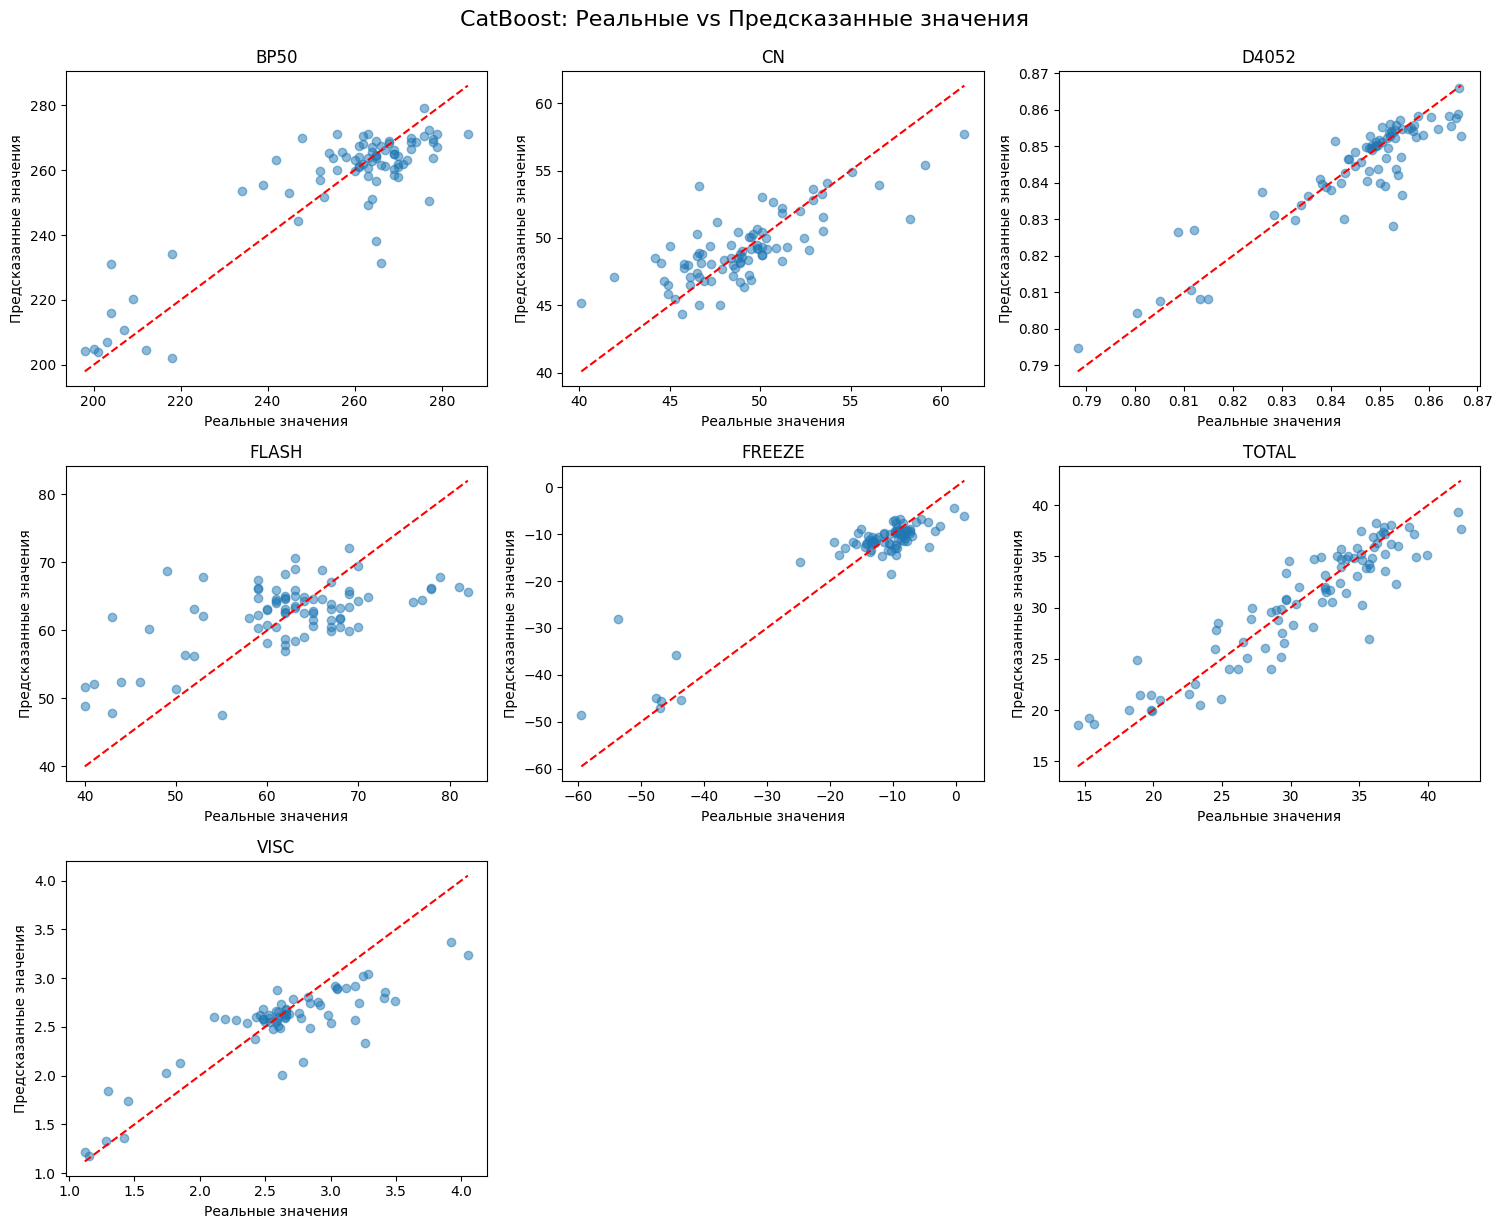

In [ ]:
# Количество графиков
n_cols = 3
n_rows = int(np.ceil(len(Y_test.columns) / n_cols))

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, target in enumerate(Y_test.columns):
    # Убираем строки с NaN в тестовом признаке
    mask = ~Y_test[target].isna()
    X_eval = X_test[mask]
    y_true = Y_test[target][mask]

    # Обучаем модель на соответствующих тренировочных данных
    train_mask = ~Y_train[target].isna()
    X_train_target = X_train[train_mask]
    y_train_target = Y_train[target][train_mask]

    model = CatBoostRegressor(**best_params, verbose=0, random_seed=42)
    model.fit(X_train_target, y_train_target)

    # Предсказания
    y_pred = model.predict(X_eval)

    # График
    plt.subplot(n_rows, n_cols, i + 1)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color="red", linestyle="--")
    plt.xlabel("Реальные значения")
    plt.ylabel("Предсказанные значения")
    plt.title(target)

plt.tight_layout()
plt.suptitle("CatBoost: Реальные vs Предсказанные значения", fontsize=16, y=1.02)
plt.show()

Что улучшилось?
- CatBoost показал более высокое среднее качество: R² = 0.6692 ± 0.0637 против 0.6004 ± 0.0885 у Ridge. Это означает, что модель объясняет на 7% больше дисперсии данных. Ошибки MSE, MAE и RMSE также снизились, особенно для признаков D4052, TOTAL, FREEZE и VISC. Наиболее заметное улучшение достигнуто на признаках с выраженной нелинейной зависимостью. В целом, CatBoost обеспечивает более точные и стабильные предсказания, хотя по-прежнему есть признаки, предсказываемые хуже (например, FLASH).

### Support Vector Regression (SVR)

Support Vector Regression — это разновидность метода опорных векторов, адаптированная для задач регрессии. Вместо поиска линейной границы между классами, как в SVM, SVR пытается найти такую функцию, которая отклоняется от истинных значений не более чем на ε, при этом оставаясь как можно проще (с минимальной нормой весов). SVR может использовать различные ядра (линейное, полиномиальное, радиальное и др.), позволяя моделировать как линейные, так и нелинейные зависимости.

План действий:
1. Удаление пропусков
- Для каждой целевой переменной удаляются строки с пропущенными значениями (обрабатываются по отдельности).
2. Формирование данных
- Используются признаки, полученные после PCA-преобразования. Целевые переменные — 7 измеряемых характеристик топлива.
3. Подбор гиперпараметров
- Используется GridSearchCV с 5-кратной кросс-валидацией для подбора следующих параметров:
  - C — коэффициент регуляризации;
  - epsilon — допуск в отклонении предсказаний от реальных значений;
  - kernel — тип ядра (линейное и RBF).
4. Обучение и оценка модели
- После подбора параметров модель обучается и оценивается с помощью 5-fold кросс-валидации. Считаются следующие метрики:
  - MSE (среднеквадратичная ошибка)
  - MAE (средняя абсолютная ошибка)
  - RMSE (корень из MSE)
  - R² (коэффициент детерминации)
5. Сводная таблица результатов
Для каждого признака выводятся значения метрик в виде среднее ± стандартное отклонение, а также рассчитываются средние значения по всем признакам.
6. Визуализация результатов

In [ ]:
# Метрики и предсказания
results = {}
y_true_dict = {}
y_pred_dict = {}
best_params_dict = {}  # Добавим словарь для хранения параметров

# Кросс-валидация
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Перебор по признакам
for target in data_prop.columns[1:]:
    data_target = data_final.dropna(subset=[target])

    X = data_target.drop(columns=["id"] + list(data_prop.columns[1:]))
    y = data_target[target]

    param_grid = {
        'kernel': ['linear', 'rbf'],
        'C': [0.1, 1, 10],
        'epsilon': [0.01, 0.1]
    }

    grid_search = GridSearchCV(SVR(), param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X, y)
    best_params = grid_search.best_params_

    # Сохраняем лучшие параметры
    best_params_dict[target] = best_params

    mse_scores, mae_scores, r2_scores = [], [], []
    y_true_all = []
    y_pred_all = []

    for train_idx, val_idx in cv.split(X):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = SVR(**best_params)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)

        mse_scores.append(mean_squared_error(y_val, y_pred))
        mae_scores.append(mean_absolute_error(y_val, y_pred))
        r2_scores.append(r2_score(y_val, y_pred))

        y_true_all.extend(y_val)
        y_pred_all.extend(y_pred)

    # Сохраняем
    y_true_dict[target] = np.array(y_true_all)
    y_pred_dict[target] = np.array(y_pred_all)

    results[target] = {
        "MSE (mean ± std)": f"{np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}",
        "MAE (mean ± std)": f"{np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}",
        "RMSE (mean ± std)": f"{np.sqrt(np.mean(mse_scores)):.4f} ± {np.sqrt(np.std(mse_scores)):.4f}",
        "R² (mean ± std)": f"{np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}",
    }

# Формируем таблицу
df_results = pd.DataFrame(results)

# Средние метрики по всем признакам
average_metrics = {}
for metric in df_results.index:
    means = [float(x.split(" ± ")[0]) for x in df_results.loc[metric]]
    stds = [float(x.split(" ± ")[1]) for x in df_results.loc[metric]]
    average_metrics[metric] = f"{np.mean(means):.4f} ± {np.mean(stds):.4f}"

df_results["Среднее (по всем признакам)"] = pd.Series(average_metrics)

# Вывод лучших параметров
print("\nЛучшие параметры по признакам:")
for target, params in best_params_dict.items():
    print(f"{target}: kernel = {params['kernel']}, C = {params['C']}, epsilon = {params['epsilon']}")

# Вывод таблицы
df_results


Лучшие параметры по признакам:
BP50: kernel = rbf, C = 10, epsilon = 0.1
CN: kernel = rbf, C = 10, epsilon = 0.1
D4052: kernel = rbf, C = 0.1, epsilon = 0.01
FLASH: kernel = linear, C = 1, epsilon = 0.1
FREEZE: kernel = rbf, C = 10, epsilon = 0.1
TOTAL: kernel = rbf, C = 10, epsilon = 0.01
VISC: kernel = rbf, C = 10, epsilon = 0.1


,BP50,CN,D4052,FLASH,FREEZE,TOTAL,VISC,Среднее (по всем признакам)
MSE (mean ± std),143.7307 ± 12.8215,6.4210 ± 0.7867,0.0000 ± 0.0000,50.9534 ± 16.6929,33.3204 ± 7.4339,6.1383 ± 2.9009,0.0826 ± 0.0035,34.3781 ± 5.8056
MAE (mean ± std),8.9305 ± 0.4296,1.9168 ± 0.0932,0.0051 ± 0.0003,5.4308 ± 0.6384,3.7855 ± 0.2632,1.8250 ± 0.2700,0.2176 ± 0.0139,3.1588 ± 0.2441
RMSE (mean ± std),11.9888 ± 3.5807,2.5340 ± 0.8870,0.0066 ± 0.0027,7.1382 ± 4.0857,5.7724 ± 2.7265,2.4776 ± 1.7032,0.2874 ± 0.0591,4.3150 ± 1.8636
R² (mean ± std),0.6575 ± 0.0462,0.4614 ± 0.0867,0.8085 ± 0.0327,0.3208 ± 0.0787,0.7530 ± 0.0327,0.8637 ± 0.0550,0.6882 ± 0.0637,0.6504 ± 0.0565


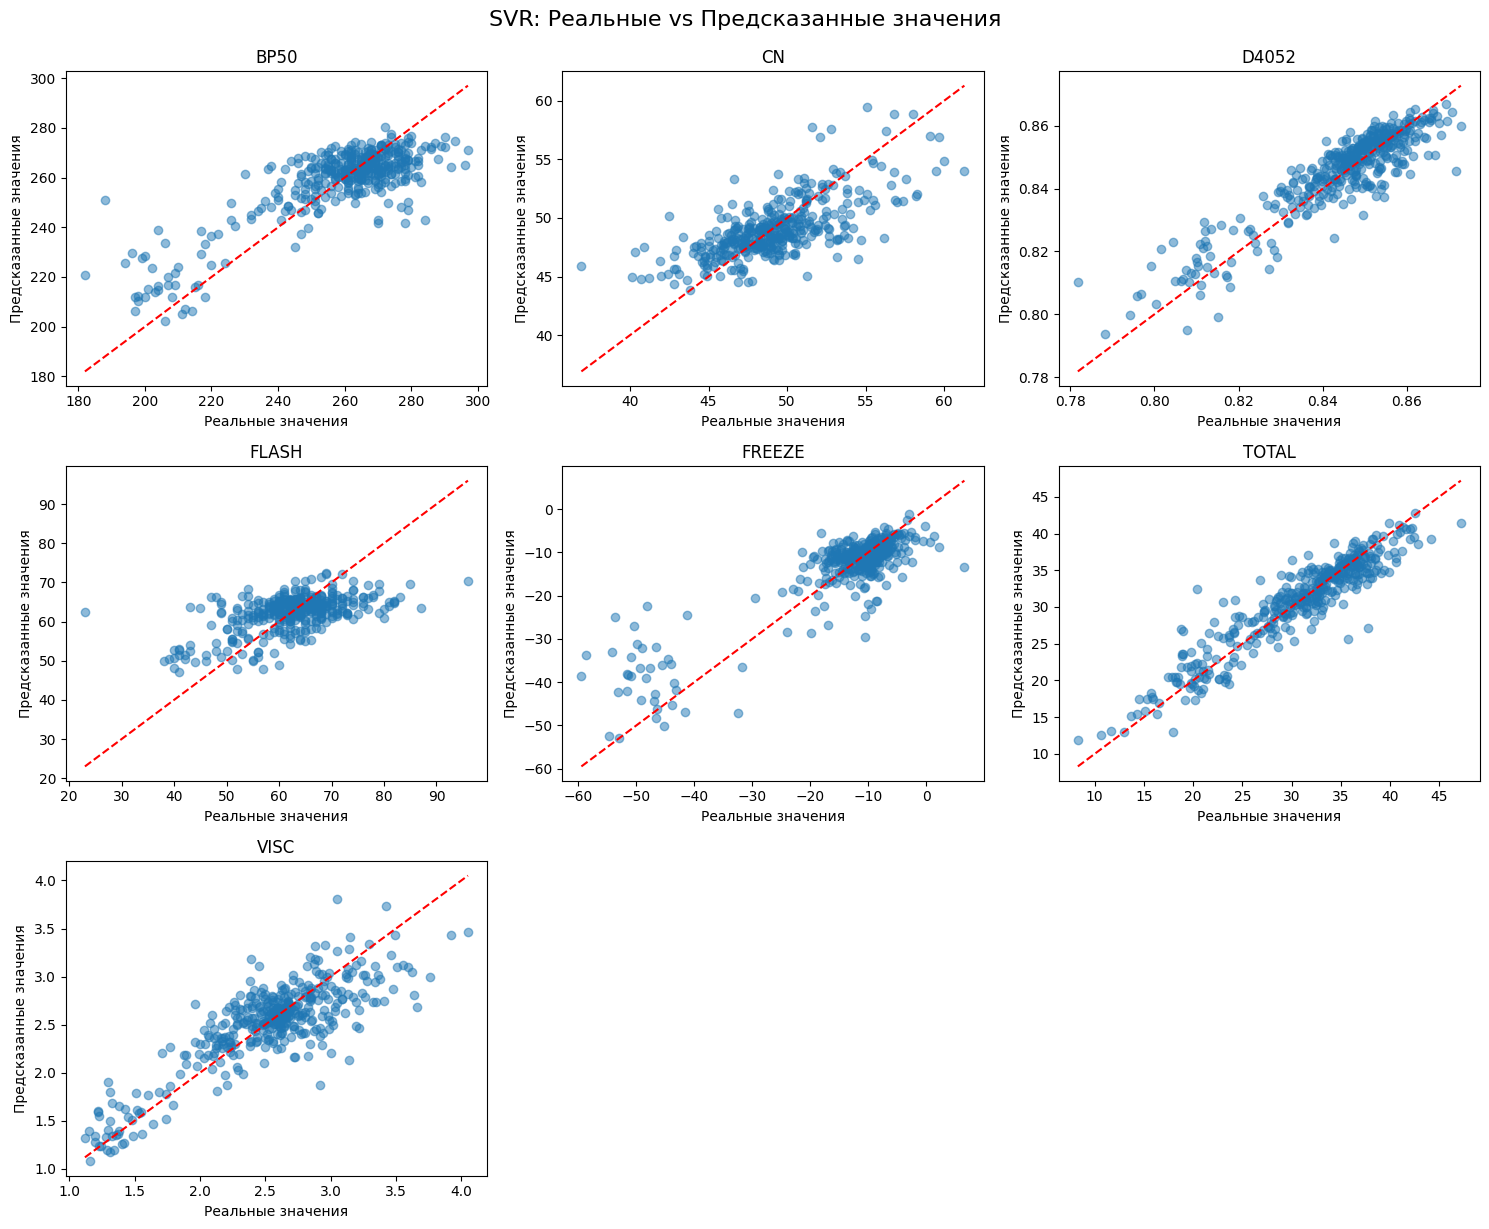

In [ ]:
# Визуализация результатов SVR: реальные vs предсказанные значения
n_cols = 3
n_rows = int(np.ceil(len(y_true_dict) / n_cols))
plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, target in enumerate(y_true_dict.keys()):
    y_true = y_true_dict[target]
    y_pred = y_pred_dict[target]

    # График
    plt.subplot(n_rows, n_cols, i + 1)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')
    plt.xlabel("Реальные значения")
    plt.ylabel("Предсказанные значения")
    plt.title(f"{target}")

plt.tight_layout()
plt.suptitle("SVR: Реальные vs Предсказанные значения", fontsize=16, y=1.02)
plt.show()

Средний R² = 0.6504 ± 0.0565, что сопоставимо с результатом CatBoost R² = 0.6692±0.0637, то есть SVR уступает буквально на 1–2%.

Метод опорных векторов для регрессии (SVR) демонстрирует почти такой же уровень качества, как CatBoost, особенно на признаках с хорошей линейной или умеренно нелинейной зависимостью. Однако при большом числе целевых переменных и необходимости подбора параметров отдельно для каждой — CatBoost оказывается более удобным и устойчивым решением, особенно благодаря встроенной многомерной регрессии и высокой автоматизации